In [1]:
import pandas as pd
import swifter
import glob

from pandarallel import pandarallel

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
files = sorted(glob.glob('data/**/*.csv', recursive=True))

In [4]:
print(len(files)) # 2017 (3), 2018 (4), 2019 (4), 2020 (12), 2021 (12), 2022 (12), 2023 (12), 2024 (9)

years_files = [3, 4, 4, 12, 12, 12, 12, 9]

68


In [5]:
columns_mapping = {'Bike Id': 'Bike Id',
 'End Station Id': 'End Station Id',
 'End Station Name': 'End Station Name',
 'End Time': 'End Time',
 'Model': 'Model',
 'Start Station Id': 'Start Station Id',
 'Start Station Name': 'Start Station Name',
 'Start Time': 'Start Time',
 'Trip  Duration': 'Trip Duration',
 'Trip Id': 'Trip Id',
 'User Type': 'User Type',
 'from_station_id': 'Start Station Id',
 'from_station_name': 'Start Station Name',
 'to_station_id': 'End Station Id',
 'to_station_name': 'End Station Name',
 'trip_duration_seconds': 'Trip Duration',
 'trip_id': 'Trip Id',
 'trip_start_time': 'Start Time',
 'trip_stop_time': 'End Time',
 'user_type': 'User Type'}

In [6]:
columns_types = {'Trip Id': 'str',
                 'Start Time': 'datetime64[ns]', 
                 'End Time': 'datetime64[ns]', 
                 'Trip Duration': 'int32', 
                 'Start Station Id': 'int32', 
                 'Start Station Name': 'str', 
                 'End Station Id': 'int32', 
                 'End Station Name': 'str', 
                 'User Type': 'str'}

incomplete_columns_types = {'Trip Id': 'str',
                 'Start Time': 'datetime64[ns]', 
                 'End Time': 'datetime64[ns]', 
                 'Trip Duration': 'int32', 
                 'Start Station Name': 'str', 
                 'End Station Name': 'str', 
                 'User Type': 'str'}

In [7]:
min_deg_in = 1
max_deg_in = 520

min_deg_out = 1
max_deg_out = 493

In [16]:
import pandas as pd
import os
from tqdm.notebook import tqdm

dfs = []

for file in tqdm(files[3:7]):

    filename = file.split(os.sep)[-1]
    
    try:
        df = pd.read_csv(file, encoding='utf-8')
    except Exception as e:
        df = pd.read_csv(file, encoding='cp1252')
        
    df_cleaned = df.dropna()  # Remove null values
    df_renamed = df_cleaned.rename(columns_mapping, axis=1) # Rename columns if necessary
    df_corrected = df_renamed.astype(columns_types)

    final_df = func1(df_corrected)

    dfs.append(final_df)


    # G, _ = func2(final_df)
    
    # nx.write_gml(G, f"networks/{filename.split('.')[0]}.gml")
    
    # degrees_in = dict(G.in_degree()).values()
    # degrees_out = dict(G.out_degree()).values()

    # min_deg_in = min(min(degrees_in), min_deg_in)
    # max_deg_in = max(max(degrees_in), max_deg_in)
    
    # min_deg_out = min(min(degrees_out), min_deg_out)
    # max_deg_out = max(max(degrees_out), max_deg_out)
    
    # func3(G, filename, deg_ext=(min_deg_in, max_deg_in, min_deg_out, max_deg_out), bins=14)
    # func3(G, filename)


  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
total_2018_df = pd.concat(dfs)

In [19]:
from datetime import date
from dateutil.relativedelta import * 

end = date.fromisoformat('2018-01-01')

for month in tqdm(range(1,13)):
    
    begin = end
    end = begin + relativedelta(months=+1)

    month_df = total_2018_df[(total_2018_df['Start Time'] > pd.to_datetime(begin)) & (total_2018_df['End Time'] < pd.to_datetime(end))]

    month_df.to_csv(f'processed/2018/month-{month}.csv')

    G, _ = func2(final_df)
    
    nx.write_gml(G, f"processed/2018/month-{month}.gml")


  0%|          | 0/12 [00:00<?, ?it/s]

In [12]:
month_df = pd.read_csv('processed/2018/month-1.csv')

In [13]:
G, _ = func2(month_df)

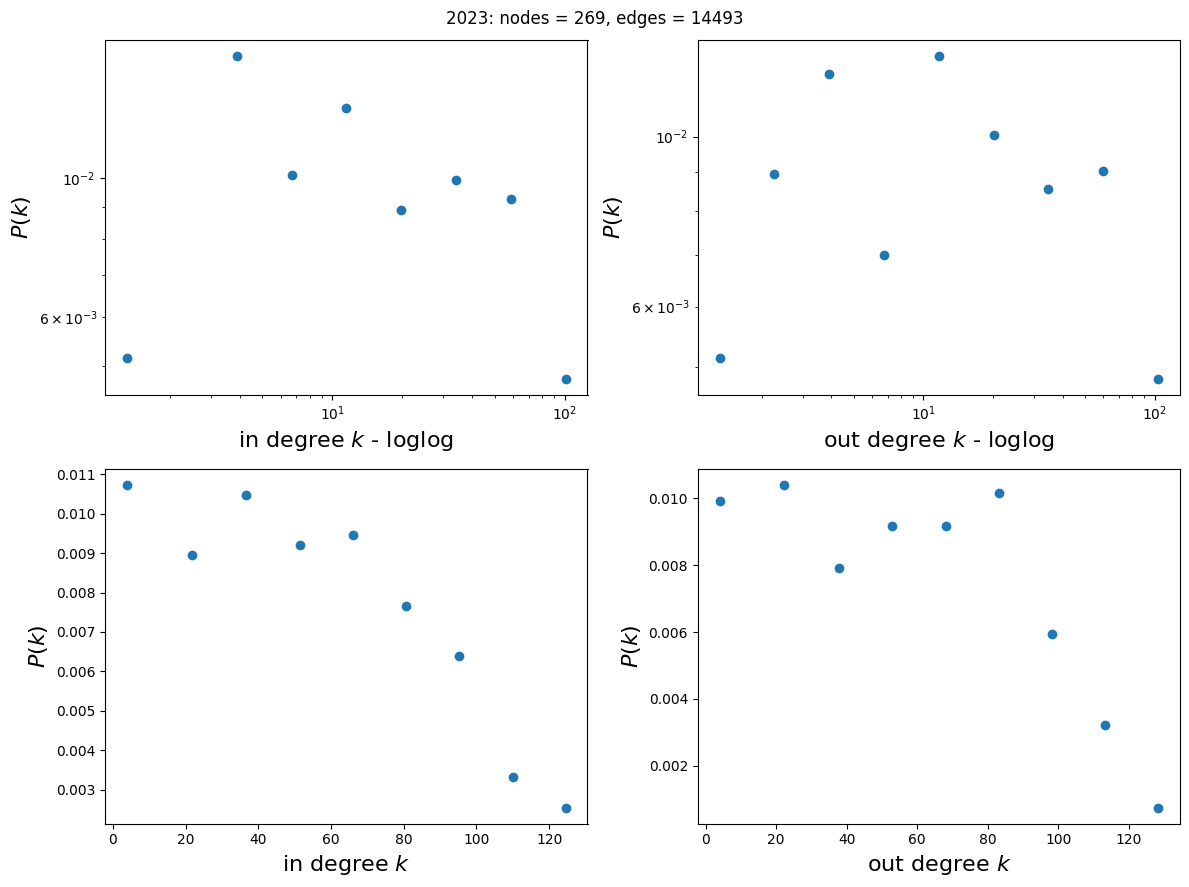

In [15]:
func3(G, name="2023")

#### one function to do it all

In [9]:
from threshold.similarity import compute_avg_similarity
import random

def get_tempdf(df):
    temp1_df = df[["Start Station Id", "Start Station Name"]].rename({'Start Station Id':'Id', 'Start Station Name': 'Name'}, axis=1)
    temp2_df = df[["End Station Id", "End Station Name"]].rename({'End Station Id':'Id', 'End Station Name': 'Name'}, axis=1)
    temp_df = pd.concat([temp1_df, temp2_df]).drop_duplicates()
    return temp_df

def change_membership(membership):
    if membership == 'Annual Member':
        return 'Member'
    elif membership == 'Casual Member':
        return 'Casual'
    else:
        return membership
        
def func1(df):
    temp_df = get_tempdf(df)
    temp_temp_df = (temp_df.groupby("Id").count() > 1).reset_index()


    threshold = 0.33
    changes = []
    
    # we are trying to find the mapping and after we've found one, we replace the duplicates
    for id in temp_temp_df[temp_temp_df['Name'] == True].Id.to_numpy():
        duplicates = temp_df[temp_df['Id'] == id]
        size = len(duplicates)
    
        similarity = compute_avg_similarity(duplicates.Name.to_numpy())
    
        if similarity > threshold:
            choice = size - 1
        else:
            choice = size
        
        # if any of the choices -> add a tuple for every other choice
        # else do nothing
        if choice < size:
            
            choice_name = duplicates.iloc[choice, 1]
    
            for i in range(size):
                if i == choice:
                    continue
                changes.append((duplicates.iloc[i, 1], choice_name))


    for change in changes:
        
        df.loc[df['Start Station Name'] == change[0], 'Start Station Name'] = change[1]
    
        df.loc[df['End Station Name'] == change[0], 'End Station Name'] = change[1]

    temp_df = get_tempdf(df)
    new_changes = []

    for id in [7117, 7130, 7291, 7381]:
        duplicates = temp_df[temp_df['Id'] == id]
        size = len(duplicates)

        if size == 0:
            continue
    
        choice = size - 1
            
        choice_name = duplicates.iloc[choice, 1]
    
        for i in range(size):
            if i == choice:
                continue
            new_changes.append((duplicates.iloc[i, 1], choice_name))


    comb_to_change = [((7001, "Lower Jarvis St / The Esplanade"), 7686)]

    for change in comb_to_change:
    
        df.loc[(df['Start Station Id'] == change[0][0]) & (df['Start Station Name'] == change[0][1]), 'Start Station Id'] = change[1]
    
        df.loc[(df['End Station Id'] == change[0][0]) & (df['End Station Name'] == change[0][1]), 'End Station Id'] = change[1]

    id_to_change = [(7720, 7372), (7685, 7322), (7712, 7072), (7680, 7510), (7792, 7098), (7470, 7398)]
    
    for change in id_to_change:
    
        df.loc[df['Start Station Id'] == change[0], 'Start Station Id'] = change[1]
    
        df.loc[df['End Station Id'] == change[0], 'End Station Id'] = change[1]

    available_ids = list(set(range(7000,8000)) - set(temp_df['Id'].unique()))

    new_id_changes = []
    
    temp_temp_df = (temp_df.groupby("Id").count() > 1).reset_index()
    
    for id in temp_temp_df[temp_temp_df['Name'] == True].Id.to_numpy():
    
        # choose one of the options to change id for
        duplicates = temp_df[temp_df['Id'] == id]
        size = len(duplicates)
    
        choice = size - 1 
        choice_name = duplicates.iloc[choice, 1]
    
        new_id = random.choice(available_ids)
        available_ids.remove(new_id)
    
        new_id_changes.append(((id, choice_name), new_id))

    for id_change in new_id_changes:
    
        df.loc[(df['Start Station Id'] == id_change[0][0]) & (df['Start Station Name'] == id_change[0][1]), 'Start Station Id'] = id_change[1]
    
        df.loc[(df['End Station Id'] == id_change[0][0]) & (df['End Station Name'] == id_change[0][1]), 'End Station Id'] = id_change[1]

    df['User Type'] = df['User Type'].apply(change_membership)

    df = df[df['Trip Duration'] > 29]

    df = df[df['Start Station Id'] != df['End Station Id']]

    df = df[df['Start Time'] < df['End Time']]

    return df

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import networkx as nx

def func2(df):
    
    whole_trips_df = df[['Start Time', 'End Time', 'Trip Id', 'Trip Duration', 'Start Station Id', 'End Station Id']]
    whole_trips_df = whole_trips_df.astype({'Start Time': 'datetime64[ns]', 'End Time': 'datetime64[ns]'})

    temp_df = whole_trips_df[['Start Time', 'End Time', 'Start Station Id', 'End Station Id', 'Trip Id']].groupby(['Start Station Id', 'End Station Id']).agg({'Trip Id': 'count', 'Start Time': 'min', 'End Time': 'max'}).reset_index().rename({'Trip Id': 'Trip Count'}, axis=1)
    temp_df['Link Duration'] = temp_df.apply(lambda x: (x['End Time'] - x['Start Time']).ceil('d'), axis=1).dt.days #.astype('timedelta64[D]')
    temp_df['Avg Duration'] = whole_trips_df[['Start Station Id', 'End Station Id', 'Trip Duration']].groupby(['Start Station Id', 'End Station Id']).mean().reset_index()['Trip Duration']
    temp_df['duration_weights'] = temp_df['Avg Duration'].apply(lambda x: 1 / x)

    temp_df['tpd_weights'] = temp_df.apply(lambda x: x['Trip Count'] / x['Link Duration'], axis=1)
    temp_df = temp_df.rename({'Trip Count': 'trip_count_weights'}, axis=1).drop(['Start Time', 'End Time', 'Link Duration', 'Avg Duration'], axis=1)

    nnp = np.percentile(temp_df[['trip_count_weights', 'duration_weights', 'tpd_weights']], 99, axis=0)
    temp_df[['trip_count_weights', 'duration_weights', 'tpd_weights']] = np.clip(temp_df[['trip_count_weights', 'duration_weights', 'tpd_weights']], None, nnp)

    min_max_scaler = MinMaxScaler((1, 10))
    x_scaled = min_max_scaler.fit_transform(temp_df[['trip_count_weights', 'duration_weights', 'tpd_weights']])
    temp_df[['trip_count_weights', 'duration_weights', 'tpd_weights']] = x_scaled

    G = nx.from_pandas_edgelist(temp_df, source="Start Station Id", target="End Station Id", edge_attr=['trip_count_weights', 'duration_weights', 'tpd_weights'], create_using=nx.DiGraph)

    node_labels = {d['Id']: d['Name'] for d in get_tempdf(df)[['Id', 'Name']].to_dict('records')}
    nx.set_node_attributes(G, node_labels, name='Name')

    return G, temp_df

In [14]:
import matplotlib.pyplot as plt

def func3(G, name, deg_ext=None, bins=9):

    # print(f"{name}:")
    nodes, edges = G.number_of_nodes(), G.number_of_edges()

    in_degrees = [deg for (id, deg) in G.in_degree() if deg > 0]
    out_degrees = [deg for (id, deg) in G.out_degree() if deg > 0]

    if deg_ext:
        in_kmin, in_kmax, out_kmin, out_kmax = deg_ext
    else:
        in_kmin = min(in_degrees)
        in_kmax = max(in_degrees)
        out_kmin = min(out_degrees)
        out_kmax = max(out_degrees)

    # Get 10 logarithmically spaced bins between kmin and kmax
    # in_bin_edges_log = np.logspace(np.log10(in_kmin + 1e-1), np.log10(in_kmax), num=bins + 1)
    # out_bin_edges_log = np.logspace(np.log10(out_kmin + 1e-1), np.log10(out_kmax), num=bins + 1)
    in_bin_edges_log = np.logspace(np.log10(in_kmin), np.log10(in_kmax), num=bins + 1)
    out_bin_edges_log = np.logspace(np.log10(out_kmin), np.log10(out_kmax), num=bins + 1)

    # histogram the data into these bins
    in_density_log, _ = np.histogram(in_degrees, bins=in_bin_edges_log, density=True)    
    out_density_log, _ = np.histogram(out_degrees, bins=out_bin_edges_log, density=True)
    
    # "x" should be midpoint (IN LOG SPACE) of each bin
    in_log_be_log = np.log10(in_bin_edges_log)
    in_x_log = 10**((in_log_be_log[1:] + in_log_be_log[:-1])/2)
    
    out_log_be_log = np.log10(out_bin_edges_log)
    out_x_log = 10**((out_log_be_log[1:] + out_log_be_log[:-1])/2)

    # Get 20 logarithmically spaced bins between kmin and kmax
    in_bin_edges = np.linspace(in_kmin, in_kmax, num=bins + 1)
    out_bin_edges = np.linspace(out_kmin, out_kmax, num=bins + 1)
    
    # histogram the data into these bins
    in_density, _ = np.histogram(in_degrees, bins=in_bin_edges, density=True)
    out_density, _ = np.histogram(out_degrees, bins=out_bin_edges, density=True)

    # "x" should be midpoint (IN LOG SPACE) of each bin
    in_log_be = np.log10(in_bin_edges)
    in_x = 10**((in_log_be[1:] + in_log_be[:-1])/2)
    
    out_log_be = np.log10(out_bin_edges)
    out_x = 10**((out_log_be[1:] + out_log_be[:-1])/2)

    fig, axis = plt.subplots(2, 2, figsize=(12,9))

    fig.suptitle(f"{name}: nodes = {nodes}, edges = {edges}")

    axis = axis.ravel()

    axis[0].loglog(in_x_log, in_density_log, marker='o', linestyle='none')
    axis[0].set_xlabel(r"in degree $k$ - loglog", fontsize=16)
    axis[0].set_ylabel(r"$P(k)$", fontsize=16)
    
    axis[1].loglog(out_x_log, out_density_log, marker='o', linestyle='none')
    axis[1].set_xlabel(r"out degree $k$ - loglog", fontsize=16)
    axis[1].set_ylabel(r"$P(k)$", fontsize=16)
    
    axis[2].plot(in_x, in_density, marker='o', linestyle='none')
    axis[2].set_xlabel(r"in degree $k$", fontsize=16)
    axis[2].set_ylabel(r"$P(k)$", fontsize=16)
    
    axis[3].plot(out_x, out_density, marker='o', linestyle='none')
    axis[3].set_xlabel(r"out degree $k$", fontsize=16)
    axis[3].set_ylabel(r"$P(k)$", fontsize=16)
    
    # save the plot
    plt.tight_layout()
    plt.show()
    # fig.savefig(f"figs3/{name.split('.')[0]}.png")
    # plt.close()
